In [ ]:
from IO.stero import *
import pickle
import scanpy as sc
import squidpy as sq
from util import *
from Algorithm.graph import *
from Algorithm.distribution import *

In [ ]:
# Load the data
gem_df = read_gem_file('F:\Adult.gem')
df = enhance_df_info(gem_df)
adata = get_anndata(df)

F:\conda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='n_genes_by_counts'>

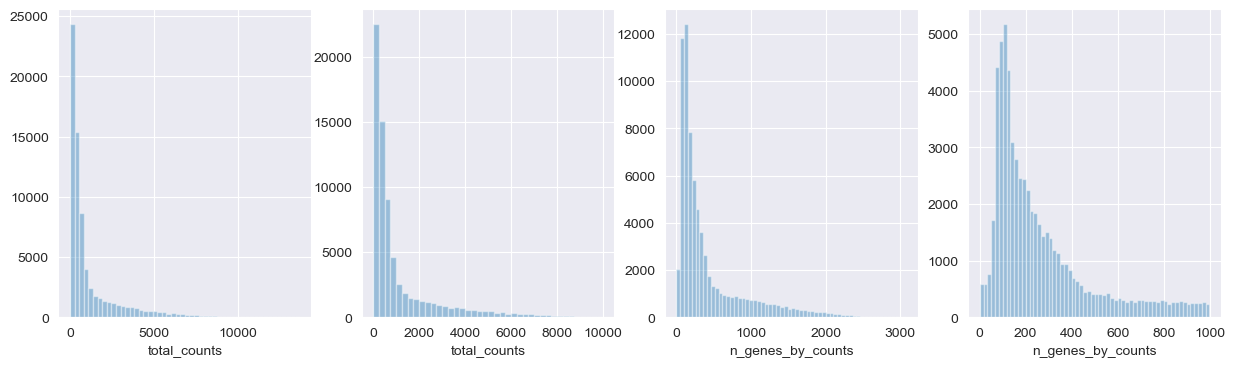

In [4]:
# filter out genes
sc.pp.filter_genes(adata, min_cells=100)
# Clean up data
sc.pp.calculate_qc_metrics(adata, inplace=True)
# Plot the raw data
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 1000], kde=False, bins=60, ax=axs[3])

In [5]:
# Normalize genes count and log1p
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
# Select top 2000 variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

In [6]:
gene_list = list(adata.var['gene_ids'])
gene_list[:5]

['AMEX60DD000045',
 'AMEX60DD000048',
 'AMEX60DD000050',
 'AMEX60DD000054',
 'AMEX60DD000066']

In [ ]:
sc.pp.

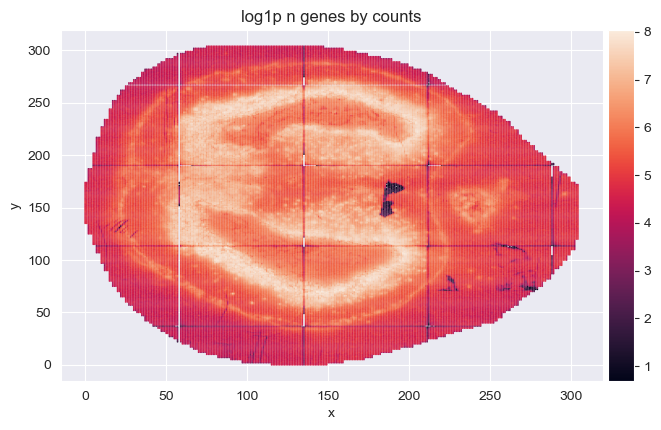

In [7]:
sc.pl.scatter(adata,
              x='x',
              y='y',
              color='log1p_n_genes_by_counts',
              size=6,
              palette=['#FF0000', '#00FF00', '#0000FF'])

In [8]:
adata.obs.keys()

Index(['cell_id', 'x', 'y', 'fig_x', 'fig_y', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'],
      dtype='object')

In [29]:
gmm_dict = {}
for i in gene_list[:200]:
    gmm_dict[i] = fit_gmm(adata, gene_name=i)

F:\conda\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  cluster.KMeans(


In [ ]:
gmm_dict = fit_gmms(adata, gene_list[:200])

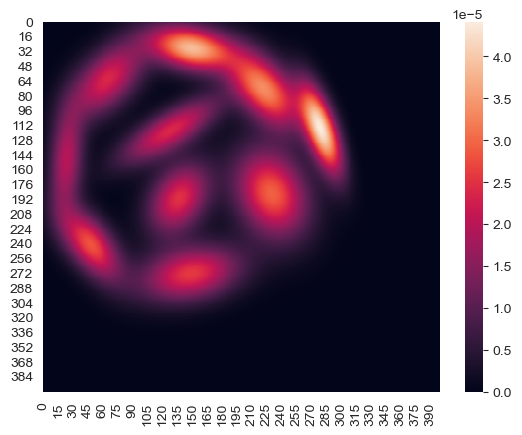

In [30]:
a = fit_gmm(adata, 'AMEX60DD000048')

view_gmm(a, (0,400),'2d')

In [38]:
test = adata.X[0].todense()

In [17]:
import numpy as np

# 创建一个示例数组
array = adata.X.todense()

# 统计每一列非零行的个数
nonzero_counts = np.count_nonzero(np.array(array), axis=0)

print(nonzero_counts)

[ 175 5446 9623 ...    1    1    1]


In [20]:
aaa = np.array(nonzero_counts)
aaa

array([ 175, 5446, 9623, ...,    1,    1,    1], dtype=int64)

In [31]:
data = np.array(adata[:, adata.var_names == 'AMEX60DD000144'].X.todense())
sparse_matrix = sparse.coo_matrix((data[:, 0], (np.array(adata.obs['x']), np.array(adata.obs['y']))))
arr = np.array(sparse_matrix.todense(), dtype=np.int32)
result = array_to_list(arr)
result

[[37, 169], [120, 89], [132, 0], [155, 277], [211, 75]]

In [17]:
gmm = mixture.GaussianMixture(n_components=10, max_iter=200)
gmm.fit(result)

GaussianMixture(max_iter=200, n_components=10)

In [18]:
gmm

GaussianMixture(max_iter=200, n_components=10)

In [ ]:
# cluster
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True)
sc.pp.neighbors(adata, n_pcs=50)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters")

In [ ]:
sc.pl.spatial(adata, spot_size=1)

In [ ]:
from scipy import sparse

# 创建一个稀疏矩阵实例作为参考类型
reference_sparse_matrix = csr_matrix([[1, 0, 2], [0, 3, 0]])

# 判断对象是否为 sparseCSRView 类型
obj = sparse.csr_matrix(reference_sparse_matrix)
is_sparse_csr_view = isinstance(obj, sparse.csr.spmatrix)
is_sparse_csr_view

In [ ]:
sc.pp.filter_genes(adata, min_cells=50)
adata

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
H = get_coor_matrix(df)